# Dealing with class imbalance

I you have had the chance of working around classification problems, then is probable you have faced a problem of imbalanced classes. This occurs in datasets with a disproportionate ratio of observations. In other words, in a binary classification problem, you’d have a lot of elements of a class and very few from another. But this could also happen in a multi-classification problem when we the vast majority of the observations are clustered in one category or we have one category that's highly under-represented in comparison with the rest.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [2]:
!pip install yellowbrick

  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0


ERROR: fbprophet 0.7.1 requires cmdstanpy==0.9.5, which is not installed.
ERROR: fbprophet 0.7.1 requires setuptools-git>=1.2, which is not installed.
ERROR: tensorflow 2.9.1 has requirement numpy>=1.20, but you'll have numpy 1.19.5 which is incompatible.
ERROR: phik 0.12.2 has requirement scipy>=1.5.2, but you'll have scipy 1.5.0 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Acesso negado: 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\~-mpy\\.libs\\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



## Load the dataset

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score

In [4]:
df = pd.read_csv('wine_data/winequality_merged.csv')
df.columns = [col.replace(' ','_') for col in df.columns]
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [5]:
df.red_wine.value_counts()

0    4898
1    1599
Name: red_wine, dtype: int64

In [6]:
df.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

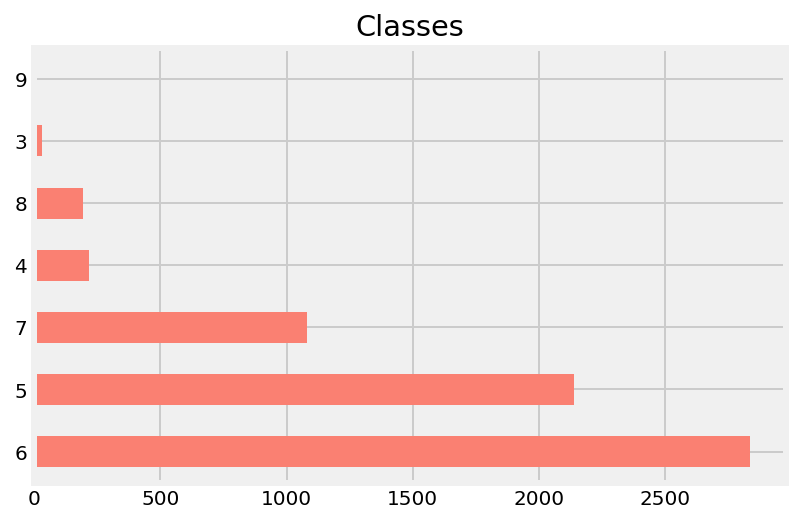

In [7]:
df.quality.value_counts().plot(kind='barh',title='Classes',color='salmon')

In [31]:
Y = df['quality']
Y

0       5
1       5
2       5
10      5
11      5
       ..
6492    6
6493    5
6494    6
6495    7
6496    6
Name: quality, Length: 6490, dtype: int64

In [32]:
X = df.drop(columns = ['quality'])
X

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,1
10,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.99590,3.28,0.54,9.2,1
11,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,0


In [86]:
def sea_plot(X,Y,label='Classes'):
    sns.scatterplot(X['alcohol'],X['chlorides'], hue = Y, palette = 'Set2')
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [85]:
def sea_plot1(X,Y,label='Classes'):
    sns.scatterplot(X['pH'],X['volatile_acidity'], hue = Y, palette = 'tab10')
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                        test_size=0.2, random_state=1)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)
X_test = pd.DataFrame(X_test,  columns=X.columns, index=y_test.index)

## Fit the model

In [42]:
def fitter(model, X_train, y_train, X_test, y_test):
    """
    Takes a model, training and test sets as inputs and evaluated the model on both 
    reporting scores, confusion matrix and classification report.
    """
    model.fit(X_train, y_train)
    print(model.score(X_train, y_train))
    print(cross_val_score(model, X_train, y_train, cv=5).mean())
    print(model.score(X_test, y_test))
    print('Confusion Matrix Train')
    print(confusion_matrix(y_train, model.predict(X_train)))
    print('Classification Report Train')
    print(classification_report(y_train, model.predict(X_train)))
    print('Confusion Matrix Test')
    print(confusion_matrix(y_test, model.predict(X_test)))
    print('Classification Report Test')
    print(classification_report(y_test, model.predict(X_test)))

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
model = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000)

In [45]:
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.538135593220339
0.5608628659476117


In [46]:
fitter(model, X_train, y_train, X_test, y_test)

0.538135593220339


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


0.5369819802277646
0.5608628659476117
Confusion Matrix Train
[[   1    0   14   11    0    0    0]
 [   0    2  111   63    1    0    0]
 [   0    0 1023  690    3    0    0]
 [   0    0  538 1662   63    0    0]
 [   0    0   59  689  106    0    0]
 [   0    0    7  116   29    0    0]
 [   0    0    0    1    3    0    0]]
Classification Report Train
              precision    recall  f1-score   support

           3       1.00      0.04      0.07        26
           4       1.00      0.01      0.02       177
           5       0.58      0.60      0.59      1716
           6       0.51      0.73      0.60      2263
           7       0.52      0.12      0.20       854
           8       0.00      0.00      0.00       152
           9       0.00      0.00      0.00         4

    accuracy                           0.54      5192
   macro avg       0.52      0.21      0.21      5192
weighted avg       0.54      0.54      0.49      5192

Confusion Matrix Test
[[  0   0   1   3   0   0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

We can put that model into a neat pipeline.

In [47]:
from sklearn.pipeline import make_pipeline

In [48]:
pipe = make_pipeline(StandardScaler(),model)

pipe.fit(X_train, y_train)

fitter(pipe, X_train, y_train, X_test, y_test)

0.538135593220339


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


0.5369819802277646
0.5608628659476117
Confusion Matrix Train
[[   1    0   14   11    0    0    0]
 [   0    2  111   63    1    0    0]
 [   0    0 1023  690    3    0    0]
 [   0    0  538 1662   63    0    0]
 [   0    0   59  689  106    0    0]
 [   0    0    7  116   29    0    0]
 [   0    0    0    1    3    0    0]]
Classification Report Train
              precision    recall  f1-score   support

           3       1.00      0.04      0.07        26
           4       1.00      0.01      0.02       177
           5       0.58      0.60      0.59      1716
           6       0.51      0.73      0.60      2263
           7       0.52      0.12      0.20       854
           8       0.00      0.00      0.00       152
           9       0.00      0.00      0.00         4

    accuracy                           0.54      5192
   macro avg       0.52      0.21      0.21      5192
weighted avg       0.54      0.54      0.49      5192

Confusion Matrix Test
[[  0   0   1   3   0   0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

## Balance the class weights

One way of treating class imbalances when using logistic regression is to use `class_weight='balanced'`.

In [41]:
model_balanced = LogisticRegression(solver='lbfgs', 
                                    multi_class='ovr', 
                                    max_iter=1000,
                                    class_weight='balanced')


fitter(model_balanced, X_train, y_train, X_test, y_test)

0.3882896764252696


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


0.3778887362051476
0.37673343605546994

[[ 11   3   5   2   1   3   1]
 [ 37  55  54  15  15   1   0]
 [179 186 985 189 115  58   4]
 [166 156 620 518 546 232  25]
 [ 46  22  91 113 380 182  20]
 [ 11   0  13  11  50  63   4]
 [  0   0   0   0   0   0   4]]

              precision    recall  f1-score   support

           3       0.02      0.42      0.05        26
           4       0.13      0.31      0.18       177
           5       0.56      0.57      0.57      1716
           6       0.61      0.23      0.33      2263
           7       0.34      0.44      0.39       854
           8       0.12      0.41      0.18       152
           9       0.07      1.00      0.13         4

    accuracy                           0.39      5192
   macro avg       0.26      0.49      0.26      5192
weighted avg       0.51      0.39      0.41      5192


[[  0   0   1   0   0   1   2]
 [  9  11   9   5   4   1   0]
 [ 51  46 241  49  18  10   3]
 [ 39  42 154 125 133  68  11]
 [ 13   5  22  27 1

## Resampling using [imbalanced learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html)

Alternatively we can use resampling methods such as undersampling and oversampling or even generate new samples.

In [49]:
#conda install -c conda-forge imbalanced-learn

In [50]:
#!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

We want to predict good or bad quality (below 5).

In [95]:
y = (Y > 4)*1
y.value_counts(normalize=True)

1    0.962096
0    0.037904
Name: quality, dtype: float64

In [97]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, 
                        test_size=0.2, random_state=1)

scaler = StandardScaler()

X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

X1_train = pd.DataFrame(X1_train, columns=X.columns, index=y1_train.index)
X1_test = pd.DataFrame(X1_test,  columns=X.columns, index=y1_test.index)

### Undersampling

We create class balance by selecting a random subset of the majority class.

In [98]:
sampler = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = sampler.fit_sample(X1_train, y1_train)

pd.Series(y_resampled).value_counts()

1    203
0    203
Name: quality, dtype: int64

In [99]:
fitter(model, X_resampled, y_resampled, X_test, y_test)

0.7142857142857143
0.6995483288166214
0.0
Confusion Matrix Train
[[139  64]
 [ 52 151]]
Classification Report Train
              precision    recall  f1-score   support

           0       0.73      0.68      0.71       203
           1       0.70      0.74      0.72       203

    accuracy                           0.71       406
   macro avg       0.72      0.71      0.71       406
weighted avg       0.72      0.71      0.71       406

Confusion Matrix Test
[[  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  2   2   0   0   0   0   0   0   0]
 [ 28  11   0   0   0   0   0   0   0]
 [205 213   0   0   0   0   0   0   0]
 [137 435   0   0   0   0   0   0   0]
 [ 24 199   0   0   0   0   0   0   0]
 [  6  35   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0]]
Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_cla

Undersampling can be used during gridsearch.

In [100]:
model = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000)

model_params = {'penalty': ['l2'],
                'C': np.logspace(-2, 2, 5)}

gs = GridSearchCV(model, model_params, cv=5)

fitter(gs, X_resampled, y_resampled, X_test, y_test)

0.7216748768472906
0.697049081601927
0.0
Confusion Matrix Train
[[138  65]
 [ 48 155]]
Classification Report Train
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       203
           1       0.70      0.76      0.73       203

    accuracy                           0.72       406
   macro avg       0.72      0.72      0.72       406
weighted avg       0.72      0.72      0.72       406

Confusion Matrix Test
[[  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  1   3   0   0   0   0   0   0   0]
 [ 27  12   0   0   0   0   0   0   0]
 [222 196   0   0   0   0   0   0   0]
 [134 438   0   0   0   0   0   0   0]
 [ 14 209   0   0   0   0   0   0   0]
 [  5  36   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0]]
Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_cla

### Oversampling

We create class balance by sampling the minority class with replacement (bootstrapping).

Be careful with the resampling and cross validation. **If you upsample before cross validation, you will have the same observations in different k-folds**

In [101]:
from imblearn.over_sampling import RandomOverSampler

In [102]:
sampler = RandomOverSampler(random_state=1)
X_resampled, y_resampled = sampler.fit_sample(X1_train, y1_train)

print(pd.Series(y_resampled).value_counts())

1    4989
0    4989
Name: quality, dtype: int64


In [103]:
fitter(model, X_resampled, y_resampled, X_test, y_test)

0.7006414111044298
0.698536421213354
0.0
Confusion Matrix Train
[[3267 1722]
 [1265 3724]]
Classification Report Train
              precision    recall  f1-score   support

           0       0.72      0.65      0.69      4989
           1       0.68      0.75      0.71      4989

    accuracy                           0.70      9978
   macro avg       0.70      0.70      0.70      9978
weighted avg       0.70      0.70      0.70      9978

Confusion Matrix Test
[[  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  3   1   0   0   0   0   0   0   0]
 [ 27  12   0   0   0   0   0   0   0]
 [199 219   0   0   0   0   0   0   0]
 [116 456   0   0   0   0   0   0   0]
 [ 22 201   0   0   0   0   0   0   0]
 [  5  36   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0]]
Classification Report Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_cla

If we want to use cross validation, we have to set it up by hand and do the oversampling **after** we have created the k-folds.

from sklearn.model_selection import GridSearchCV

In [33]:
"""---------------------"""
# wrong way
"""---------------------"""

model = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000)

model_params = {'penalty': ['l2'],
                'C': np.logspace(-2, 2, 5)}

gs = GridSearchCV(model, model_params, cv=5)
fitter(gs, X_resampled, y_resampled, X_test, y_test)

0.7202
0.7211000000000001
0.7638461538461538

[[3430 1570]
 [1228 3772]]

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      5000
           1       0.71      0.75      0.73      5000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000


[[ 29  20]
 [287 964]]

              precision    recall  f1-score   support

           0       0.09      0.59      0.16        49
           1       0.98      0.77      0.86      1251

    accuracy                           0.76      1300
   macro avg       0.54      0.68      0.51      1300
weighted avg       0.95      0.76      0.84      1300



In [108]:
from sklearn.model_selection import StratifiedKFold

In [111]:
"""---------------------"""
# correct way
"""---------------------"""

kf = StratifiedKFold(n_splits=5)

for C_current in np.logspace(-2, 4, 10):
    model = LogisticRegression(C=C_current, solver='lbfgs', multi_class='ovr', max_iter=1000)
    
    scores = []
    for train, test in kf.split(X1_train, y1_train):
        X_train_now, X_test_now = X1_train.iloc[train, :], X1_train.iloc[test, :]
        y_train_now, y_test_now = y1_train.iloc[train], y1_train.iloc[test]

        X_resampled, y_resampled = sampler.fit_sample(X_train_now, y_train_now)

        model.fit(X_resampled, y_resampled)
        scores.append(model.score(X_test_now, y_test_now))

    print(np.round(C_current, 3), '\t', 
          np.round(np.mean(scores), 3), '\t', 
          np.round(model.score(X_test, y_test), 3))
    print()

0.01 	 0.748 	 0.0

0.046 	 0.746 	 0.0

0.215 	 0.746 	 0.0

1.0 	 0.746 	 0.0

4.642 	 0.746 	 0.0

21.544 	 0.746 	 0.0

100.0 	 0.746 	 0.0

464.159 	 0.746 	 0.0

2154.435 	 0.746 	 0.0

10000.0 	 0.746 	 0.0



### Using a pipeline

With imbalancedlearn's pipeline wrapper, we can use sampling without danger.

In [113]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb

In [114]:
pipe = make_pipeline_imb(RandomOverSampler(random_state=1),
                         LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000))

pipe.fit(X1_train, y1_train)
predictions = pipe.predict(X1_test)


fitter(pipe, X1_train, y1_train, X1_test, y1_test)

0.7430662557781201
0.741519469031472
0.726502311248074
Confusion Matrix Train
[[ 134   69]
 [1265 3724]]
Classification Report Train
              precision    recall  f1-score   support

           0       0.10      0.66      0.17       203
           1       0.98      0.75      0.85      4989

    accuracy                           0.74      5192
   macro avg       0.54      0.70      0.51      5192
weighted avg       0.95      0.74      0.82      5192

Confusion Matrix Test
[[ 30  13]
 [342 913]]
Classification Report Test
              precision    recall  f1-score   support

           0       0.08      0.70      0.14        43
           1       0.99      0.73      0.84      1255

    accuracy                           0.73      1298
   macro avg       0.53      0.71      0.49      1298
weighted avg       0.96      0.73      0.81      1298



The next two methods, SMOTE and ADASYN, create synthetic samples, i.e. new samples for restoring class balance, which were not contained in the original dataset. They are created by looking at  the k-nearest neighbors.

### Oversampling with SMOTE

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

Synthetic Minority Oversampling TEchnique: SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

… SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

In [148]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

In [116]:
sampler = SMOTE(random_state=1)
X_resampled, y_resampled = sampler.fit_sample(X1_train, y1_train)

pd.Series(y_resampled).value_counts()

1    4989
0    4989
Name: quality, dtype: int64

In [117]:
pipe = make_pipeline_imb(SMOTE(random_state=1),
                         LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000))

pipe.fit(X1_train, y1_train)
predictions = pipe.predict(X1_test)


fitter(pipe, X1_train, y1_train, X1_test, y1_test)

0.7457627118644068
0.7457593172625969
0.7395993836671803
Confusion Matrix Train
[[ 133   70]
 [1250 3739]]
Classification Report Train
              precision    recall  f1-score   support

           0       0.10      0.66      0.17       203
           1       0.98      0.75      0.85      4989

    accuracy                           0.75      5192
   macro avg       0.54      0.70      0.51      5192
weighted avg       0.95      0.75      0.82      5192

Confusion Matrix Test
[[ 32  11]
 [327 928]]
Classification Report Test
              precision    recall  f1-score   support

           0       0.09      0.74      0.16        43
           1       0.99      0.74      0.85      1255

    accuracy                           0.74      1298
   macro avg       0.54      0.74      0.50      1298
weighted avg       0.96      0.74      0.82      1298



### Oversampling with ADASYN

https://medium.com/@ruinian/an-introduction-to-adasyn-with-code-1383a5ece7aa#:~:text=ADASYN%20(Adaptive%20Synthetic)%20is%20an,%E2%80%9Charder%20to%20learn%E2%80%9D%20examples.

ADASYN (Adaptive Synthetic) is an algorithm that generates synthetic data, and its greatest advantages are not copying the same minority data, and generating more data for “harder to learn” examples.

The key difference between ADASYN and SMOTE is that the former uses a density distribution, as a criterion to automatically decide the number of synthetic samples that must be generated for each minority sample by adaptively changing the weights of the different minority samples to compensate for the skewed distributions. The latter generates the same number of synthetic samples for each original minority sample.

In [118]:
from imblearn.over_sampling import ADASYN

In [119]:
sampler = ADASYN(random_state=1, n_neighbors=5)
X_resampled, y_resampled = sampler.fit_sample(X1_train, y1_train)

pd.Series(y_resampled).value_counts()

0    5001
1    4989
Name: quality, dtype: int64

In [120]:
pipe = make_pipeline_imb(ADASYN(random_state=1, n_neighbors=5),
                         LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000))

pipe.fit(X1_train, y1_train)
predictions = pipe.predict(X1_test)


fitter(pipe, X1_train, y1_train, X1_test, y1_test)

0.7422958397534669
0.7369003840583339
0.7395993836671803
Confusion Matrix Train
[[ 137   66]
 [1272 3717]]
Classification Report Train
              precision    recall  f1-score   support

           0       0.10      0.67      0.17       203
           1       0.98      0.75      0.85      4989

    accuracy                           0.74      5192
   macro avg       0.54      0.71      0.51      5192
weighted avg       0.95      0.74      0.82      5192

Confusion Matrix Test
[[ 31  12]
 [326 929]]
Classification Report Test
              precision    recall  f1-score   support

           0       0.09      0.72      0.15        43
           1       0.99      0.74      0.85      1255

    accuracy                           0.74      1298
   macro avg       0.54      0.73      0.50      1298
weighted avg       0.96      0.74      0.82      1298



In [121]:
from imblearn.combine import SMOTETomek

In [155]:
smtom = SMOTETomek()
pipe1 = make_pipeline_imb(smtom,
                         LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000))

pipe1.fit(X1_train, y1_train)
predictions = pipe1.predict(X1_test)


fitter(pipe1, X1_train, y1_train, X1_test, y1_test)

0.7430662557781201
0.7451809116888367
0.7349768875192604
Confusion Matrix Train
[[ 135   68]
 [1266 3723]]
Classification Report Train
              precision    recall  f1-score   support

           0       0.10      0.67      0.17       203
           1       0.98      0.75      0.85      4989

    accuracy                           0.74      5192
   macro avg       0.54      0.71      0.51      5192
weighted avg       0.95      0.74      0.82      5192

Confusion Matrix Test
[[ 31  12]
 [332 923]]
Classification Report Test
              precision    recall  f1-score   support

           0       0.09      0.72      0.15        43
           1       0.99      0.74      0.84      1255

    accuracy                           0.73      1298
   macro avg       0.54      0.73      0.50      1298
weighted avg       0.96      0.73      0.82      1298



Visualizing under sampler and over sampler in comparison with the original df

In [132]:
undersampler = RandomUnderSampler(random_state=1)
X_under, Y_under = undersampler.fit_sample(X,Y)

In [141]:
Y.value_counts()

6    2835
5    2134
7    1077
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [160]:
smtom = SMOTETomek(sampling_strategy='minority')
X_smtom, Y_smtom = smtom.fit_sample(X,Y)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 6

In [ ]:
bsmote = BorderlineSMOTE(random_state=1)
X_bsmo, Y_bsmo = bsmote.fit_sample(X,Y)

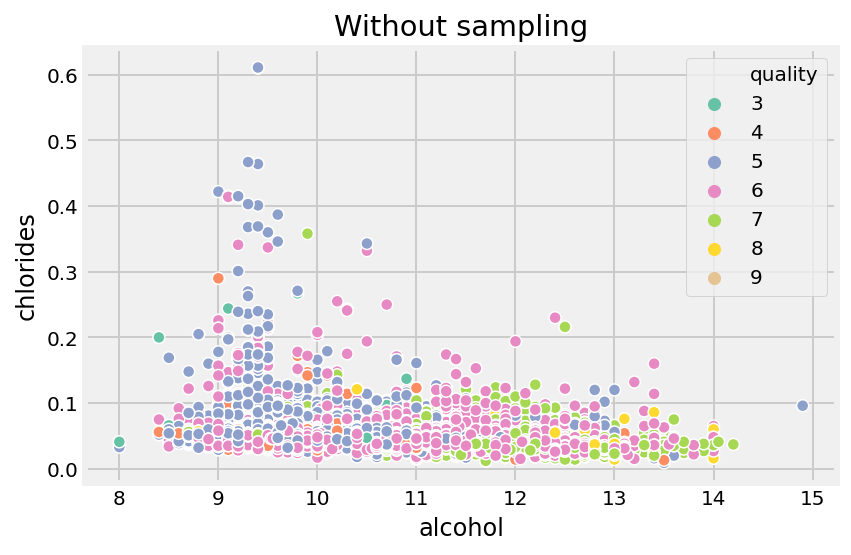

In [88]:
sea_plot(X,Y,'Without sampling')

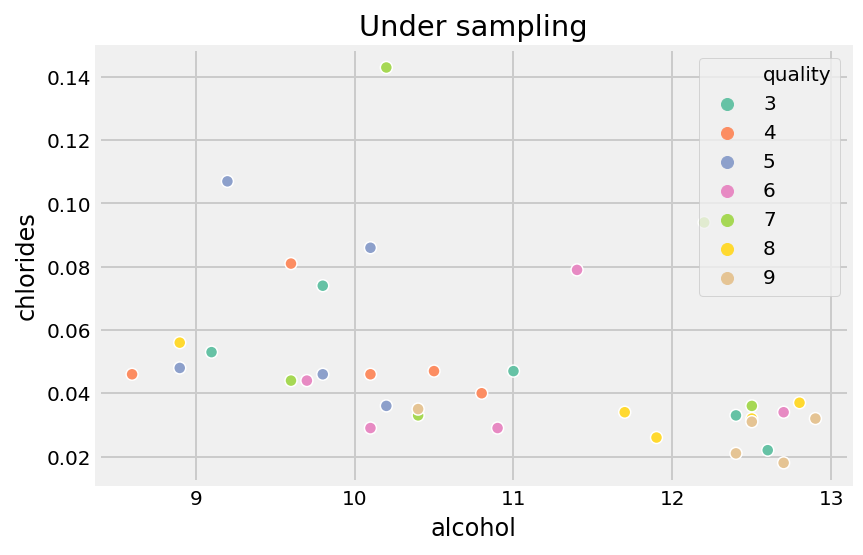

In [133]:
sea_plot(X_under,Y_under,'Under sampling')

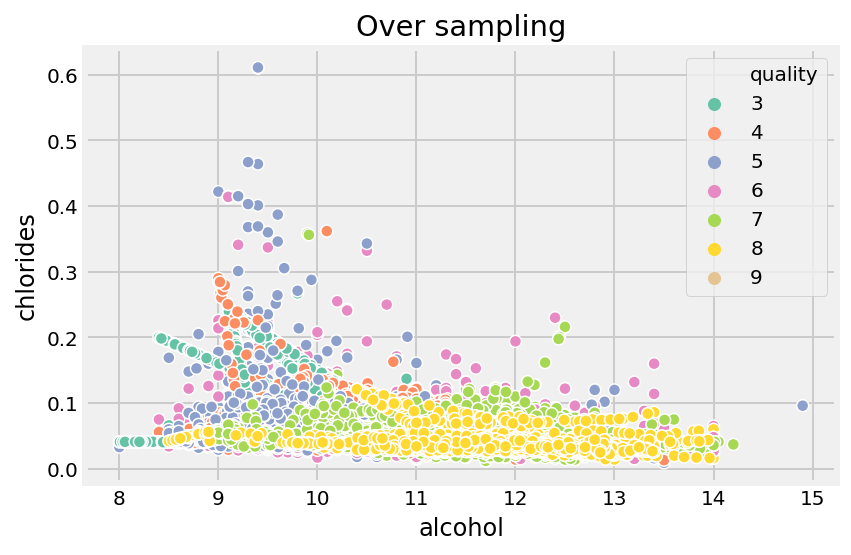

In [153]:
sea_plot(X_bsmo,Y_bsmo,'Over sampling')

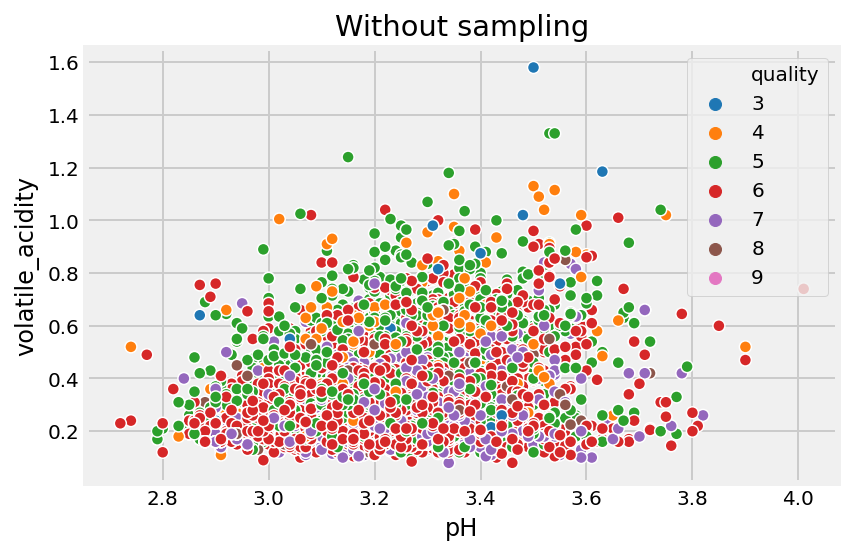

In [87]:
sea_plot1(X,Y,'Without sampling')

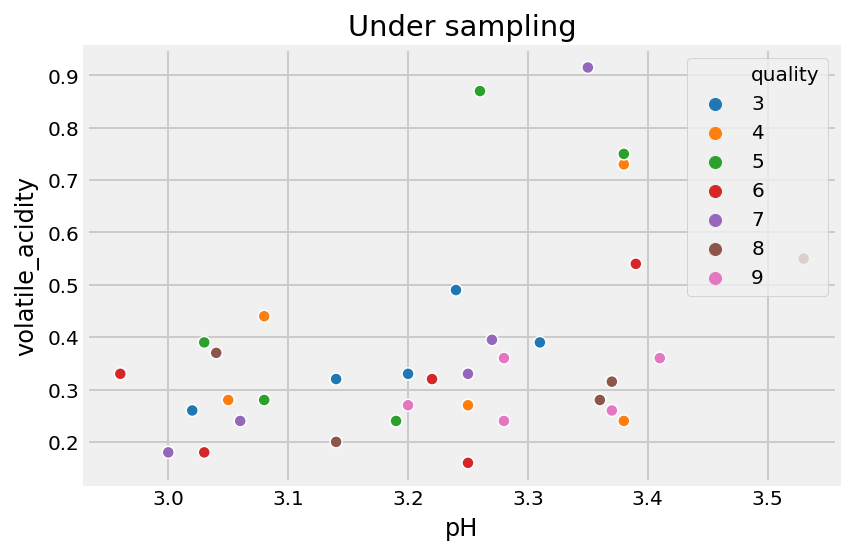

In [134]:
sea_plot1(X_under,Y_under,'Under sampling')

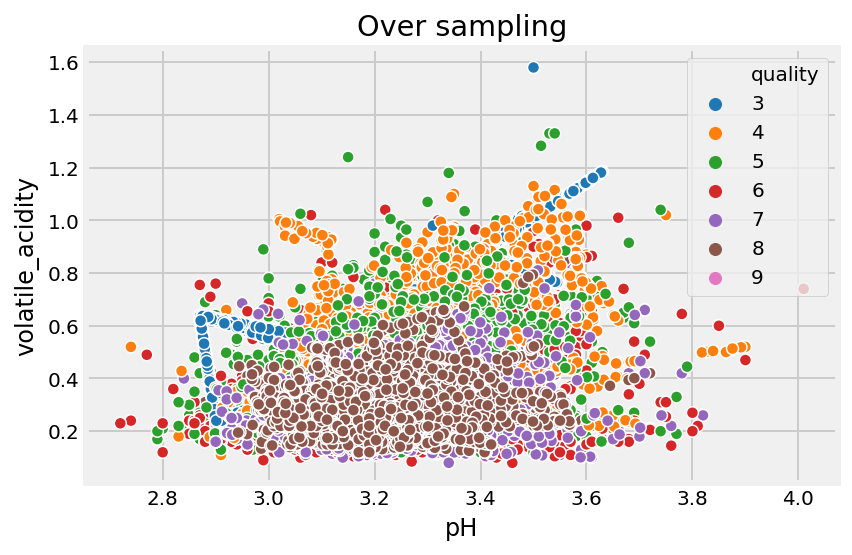

In [154]:
sea_plot1(X_bsmo,Y_bsmo,'Over sampling')